In [1]:
import pandas

print("Importing categorized names... ")
names = pandas.read_csv("data/names_cat.csv", usecols=["name", "n_publs", "likely_gender", "score"])
print("Names imported.")

Importing categorized names... 
Names imported.


In [2]:
# Setting index & accessing cells: https://pythonhow.com/accessing-dataframe-columns-rows-and-cells/
names = names.set_index("name", drop = False)
print(names[:10])

                                        name  n_publs likely_gender  score
name                                                                      
'Maseka Lesaoana            'Maseka Lesaoana        2        female      8
(David) Jing Dai            (David) Jing Dai        1          male      7
(Max) Zong-Ming Cheng  (Max) Zong-Ming Cheng        2          male      2
(Sophy) Shu-Jiun Chen  (Sophy) Shu-Jiun Chen        2        female      7
(Zhou) Bryan Bai            (Zhou) Bryan Bai        2          male      6
A Clara Kanmani              A Clara Kanmani        1        female      4
A Lun                                  A Lun        1          male      1
A Min Tjoa                        A Min Tjoa      211          male      2
A S Akshaya                      A S Akshaya        1          male      2
A'ang Subiyakto              A'ang Subiyakto        2        female      0


In [ ]:
# Get first name and last name from full name with NamSor
# Calculate the gender + score for the full name for those names with a score less than 7
# Save the new result (gender and score) in the df
# Compare the results. 
# To test if this makes sense: 
# Get sample of names with score less than 7
# send to api
# save results
# row: gender changed?: bool
# how much score changed?: int
# plot

In [3]:
print("Getting private key... ")
# Get private API Key for NamSor API v2 (contained in txt file)
key = ''

# Import personal key
with open("key.txt", "r") as file:
    key = file.read()

if(len(key) > 0):
    print("Got private key.")
else: 
    print("Could not find private key. Please check the file name and make sure you have an API key.")

Getting private key... 
Got private key.


In [4]:
# Setting up NamSor API v2 to get the gender of a name
# https://www.namsor.com/
# https://v2.namsor.com/NamSorAPIv2/apidoc.html
# using NamSor API v2 Python SDK
# https://github.com/namsor/namsor-python-sdk2
# licensed under GNU Affero General Public License v3.0

# Following script partly taken from https://github.com/namsor/namsor-python-sdk2 "Getting Started" 
# and adapted to keep key private and remove unnecessary lines.

print("Setting up NamSor API v2 connection settings...")

import openapi_client
from openapi_client.rest import ApiException

# Configure API key authorization: api_key
configuration = openapi_client.Configuration()
configuration.api_key['X-API-KEY'] = key
# create an instance of the API class
pers_api_instance = openapi_client.PersonalApi(openapi_client.ApiClient(configuration))

Setting up NamSor API v2 connection settings...


In [34]:
names_to_consider = names[names['score'] <= 8].sample(1000)
print("Will be parsing and reconsidering {} names.".format(len(names_to_consider)))

Will be parsing and reconsidering 1000 names.


In [35]:
# clean up names
# Strip numbers from a string: https://stackoverflow.com/questions/16849109/strip-out-numbers-from-a-string
# Remove white space at end from string: https://stackoverflow.com/questions/2372573/how-do-i-remove-whitespace-from-the-end-of-a-string-in-python
import re

def clean(x):
    return pandas.Series([x, re.sub(r'\d+','',x).rstrip()], index=['name', 'clean_name'])
                         
cleaned_names = names_to_consider['name'].apply(clean)
cleaned_names = cleaned_names.set_index('name')

names_to_consider=names_to_consider.merge(cleaned_names, how='left', left_index=True, right_index=True)

In [36]:
names_to_consider[:10]

,name,n_publs,likely_gender,score,clean_name
name,,,,,
Irfan Mulyawan Malik,Irfan Mulyawan Malik,1,male,6,Irfan Mulyawan Malik
L. Allan Grimm,L. Allan Grimm,1,male,4,L. Allan Grimm
Erick Amador,Erick Amador,3,male,7,Erick Amador
Roberta Di Gennaro,Roberta Di Gennaro,2,female,1,Roberta Di Gennaro
Santiago Jácome G,Santiago Jácome G,1,male,7,Santiago Jácome G
Sebastiano Panichella,Sebastiano Panichella,51,male,8,Sebastiano Panichella
Yingqing Guo,Yingqing Guo,3,male,2,Yingqing Guo
Farzan Farbiz,Farzan Farbiz,2,male,3,Farzan Farbiz
A. D. Georgantas,A. D. Georgantas,1,male,2,A. D. Georgantas


In [37]:
# Formatting the names using the API's models
def createPersonalNameIn(name_entry):
    return openapi_client.PersonalNameIn(id=name_entry['name'], name=name_entry['clean_name'])

In [38]:
# Now parsing the full names into first and last name, sending in
# one batch at a time and saving the result answer by answer.
# If the API calling gets interrupted:
# 1. check that no names got lost: ((len(names_to_consider)-len(result)) == len(names_stack))
# 2. If True: Restart only the code in the while loop.

batch_size = 1000 #1000 is the API limit given by NamSor
start = 0
end = batch_size
result = []

names_stack = names_to_consider[['name', 'clean_name']].to_dict('records')

print(names_stack[:10])

[{'name': 'Irfan Mulyawan Malik', 'clean_name': 'Irfan Mulyawan Malik'}, {'name': 'L. Allan Grimm', 'clean_name': 'L. Allan Grimm'}, {'name': 'Erick Amador', 'clean_name': 'Erick Amador'}, {'name': 'Roberta Di Gennaro', 'clean_name': 'Roberta Di Gennaro'}, {'name': 'Santiago Jácome G', 'clean_name': 'Santiago Jácome G'}, {'name': 'Sebastiano Panichella', 'clean_name': 'Sebastiano Panichella'}, {'name': 'Yingqing Guo', 'clean_name': 'Yingqing Guo'}, {'name': 'Farzan Farbiz', 'clean_name': 'Farzan Farbiz'}, {'name': 'A. D. Georgantas', 'clean_name': 'A. D. Georgantas'}, {'name': 'Yasutomo Shirakawa', 'clean_name': 'Yasutomo Shirakawa'}]


In [39]:
while (len(names_stack) >= batch_size):
    try:
        current_batch = list(map(createPersonalNameIn, names_stack[start:end])) # create batch of names in correct format
        batch_personal_name_in = openapi_client.BatchPersonalNameIn(personal_names=current_batch) # convert batch to correct format
        api_response = pers_api_instance.parse_name_batch(batch_personal_name_in=batch_personal_name_in) # call API
        result = result + api_response.personal_names # save result
        
        del names_stack[start:end] # delete the names that have already been categorized from the stack
        
        # categorize remaining names if they are less than a batch size
        if(len(names_stack) < batch_size and len(names_stack) > 0):
            current_batch = list(map(createPersonalNameIn, names_stack)) # create the batch of remaining names
            batch_personal_name_in = openapi_client.BatchPersonalNameIn(personal_names=current_batch)
            api_response = pers_api_instance.parse_name_batch(batch_personal_name_in=batch_personal_name_in)
            result = result + api_response.personal_names
            names_stack = [] # empty the stack
        
        print("Batch of names analyzed")
    except ApiException as e:
        print("Exception when calling PersonalApi: gender_full_batch: %s\n" % e)


print("All batches analyzed.")

Batch of names analyzed
All batches analyzed.


In [40]:
# Convert results (list of openapi_client.models.PersonalNameParsedOut) to (list of dictionaries)
print('Filling the results into the names dataframe...')
for oapi_el in result:
    name = oapi_el.first_last_name
    try:
        names_to_consider.at[oapi_el.id, 'first_name'] = name.first_name
        names_to_consider.at[oapi_el.id, 'last_name'] = name.last_name
    except:
        names_to_consider.at[oapi_el.id, 'first_name'] = None
        names_to_consider.at[oapi_el.id, 'last_name'] = None
    
print('Dataframe completed with API results. Here is a sample: {}'.format(names_to_consider[:10]))

Filling the results into the names dataframe...
Dataframe completed with API results. Here is a sample:                                         name  n_publs likely_gender  score  \
name                                                                         
Irfan Mulyawan Malik    Irfan Mulyawan Malik        1          male      6   
L. Allan Grimm                L. Allan Grimm        1          male      4   
Erick Amador                    Erick Amador        3          male      7   
Roberta Di Gennaro        Roberta Di Gennaro        2        female      1   
Santiago Jácome G          Santiago Jácome G        1          male      7   
Sebastiano Panichella  Sebastiano Panichella       51          male      8   
Yingqing Guo                    Yingqing Guo        3          male      2   
Farzan Farbiz                  Farzan Farbiz        2          male      3   
A. D. Georgantas            A. D. Georgantas        1          male      2   
Yasutomo Shirakawa        Yasutomo Shi

In [41]:
print("Saving test names...")
names_to_consider.to_csv("data/names_improvement_test_2.csv")
print("Test names saved!")

Saving test names...
Test names saved!


In [42]:
# Formatting the names using the API's models
import math

def createParsedPersonalNameIn(names_entry):
    if(names_entry['first_name'] is None or names_entry['last_name'] is None):
        return None
    return openapi_client.FirstLastNameIn(id=names_entry['name'], first_name=names_entry['first_name'], last_name=names_entry['last_name'])

In [43]:
# Now parsing the full names into first and last name, sending in
# one batch at a time and saving the result answer by answer.
# If the API calling gets interrupted:
# 1. check that no names got lost: ((len(names_to_consider)-len(result)) == len(names_stack))
# 2. If True: Restart only the code in the while loop.

batch_size = 1000 #1000 is the API limit given by NamSor
start = 0
end = batch_size
result = []

names_stack = list(names_to_consider[['name', 'first_name', 'last_name']].to_dict('records'))
names_stack = list(filter(lambda x: x['first_name'] is not None and x['last_name'] is not None, names_stack))

In [44]:
while (len(names_stack) >= batch_size):
    try:
        current_batch = list(map(createParsedPersonalNameIn, names_stack[start:end])) # create batch of names in correct format
        batch_first_last_name_in = openapi_client.BatchFirstLastNameIn(personal_names=current_batch) # convert batch to correct format
        api_response = pers_api_instance.gender_batch(batch_first_last_name_in=batch_first_last_name_in) # call API
        result = result + api_response.personal_names # save result
        
        del names_stack[start:end] # delete the names that have already been categorized from the stack
        
        # categorize remaining names if they are less than a batch size
        if(len(names_stack) < batch_size and len(names_stack) > 0):
            current_batch = list(map(createParsedPersonalNameIn, names_stack)) # create the batch of remaining names
            batch_first_last_name_in = openapi_client.BatchFirstLastNameIn(personal_names=current_batch)
            api_response = pers_api_instance.gender_batch(batch_first_last_name_in=batch_first_last_name_in)
            result = result + api_response.personal_names
            names_stack = [] # empty the stack
        
        print("Batch of names analyzed")
    except ApiException as e:
        print("Exception when calling PersonalApi: gender_full_batch: %s\n" % e)

if(len(names_stack) != 0):
    try:
        current_batch = list(map(createParsedPersonalNameIn, names_stack)) # create the batch of remaining names
        batch_first_last_name_in = openapi_client.BatchFirstLastNameIn(personal_names=current_batch)
        api_response = pers_api_instance.gender_batch(batch_first_last_name_in=batch_first_last_name_in)
        result = result + api_response.personal_names
        names_stack = [] # empty the stack
        
        print("Batch of names analyzed")
    except ApiException as e:
        print("Exception when calling PersonalApi: gender_full_batch: %s\n" % e)

print("All batches analyzed. Returned {} results.".format(len(result)))

Batch of names analyzed
All batches analyzed. Returned 999 results.


In [47]:
# Convert results (list of openapi_client.models.personal_name_gendered_out.PersonalNameGenderedOut) to (list of dictionaries)
print('Filling the results into the names dataframe...')
for oapi_el in result:
    names_to_consider.at[oapi_el.id, 'likely_gender_2'] = oapi_el.likely_gender
    names_to_consider.at[oapi_el.id, 'score_2'] = round(oapi_el.score)
    gender_dif = (names_to_consider.at[oapi_el.id, 'likely_gender'] != names_to_consider.at[oapi_el.id, 'likely_gender_2'])
    if (gender_dif):
        g_val = 1
    names_to_consider.at[oapi_el.id, 'gender_dif'] = gender_dif
    names_to_consider.at[oapi_el.id, 'score_dif'] = (names_to_consider.at[oapi_el.id, 'score_2'] - names_to_consider.at[oapi_el.id, 'score'])

print('Dataframe completed with API results. Here is a sample: {}'.format(names_to_consider[:50]))

Filling the results into the names dataframe...
Dataframe completed with API results. Here is a sample:                                                               name  n_publs  \
name                                                                          
Irfan Mulyawan Malik                          Irfan Mulyawan Malik        1   
L. Allan Grimm                                      L. Allan Grimm        1   
Erick Amador                                          Erick Amador        3   
Roberta Di Gennaro                              Roberta Di Gennaro        2   
Santiago Jácome G                                Santiago Jácome G        1   
Sebastiano Panichella                        Sebastiano Panichella       51   
Yingqing Guo                                          Yingqing Guo        3   
Farzan Farbiz                                        Farzan Farbiz        2   
A. D. Georgantas                                  A. D. Georgantas        1   
Yasutomo Shirakawa         

In [48]:
print("Saving test names...")
names_to_consider.to_csv("data/names_improvement_test_3.csv")
print("Test names saved!")

Saving test names...
Test names saved!


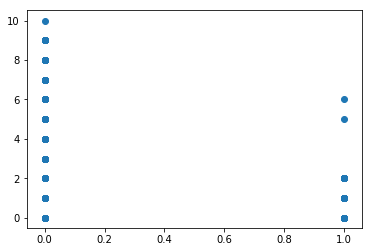

In [49]:
import matplotlib.pyplot as plt

plt.scatter(x=names_to_consider['gender_dif'], y=names_to_consider['score_2'])

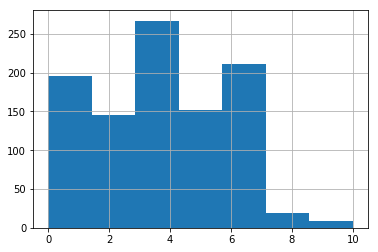

In [50]:
names_to_consider['score_2'].hist(bins=7)

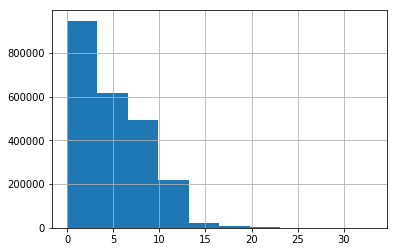

In [53]:
names['score'].hist()

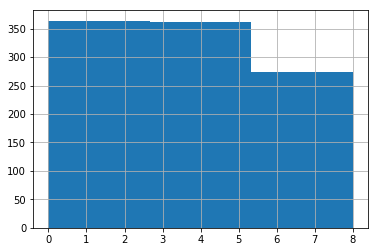

In [51]:
names_to_consider['score'].hist(bins=3)

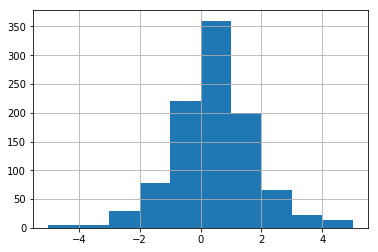

In [54]:
names_to_consider['score_dif'].hist()

In [55]:
names_by_score_dif = names_to_consider.groupby(['score_dif', 'gender_dif'])

In [56]:
names_by_score_dif = names_by_score_dif.agg({'score':'count'}) # score just counts how many entries there are per score_dif and gender_dif

In [57]:
score_diffs = list(map(lambda x: x[0], names_by_score_dif.index.values))
gender_diffs = list(map(lambda x: x[1], names_by_score_dif.index.values))

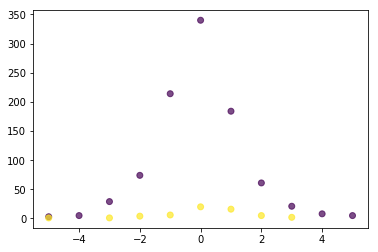

In [58]:
plt.scatter(x=score_diffs, y=names_by_score_dif['score'], c=gender_diffs, alpha=0.7)

In [59]:
descriptive_statistics_improved_names_sample1 = names_to_consider.describe()
descriptive_statistics_improved_names_sample1

,n_publs,score,score_2,score_dif
count,1000.000000,1000.00000,999.000000,999.000000
mean,6.180000,3.77100,3.725726,-0.048048
std,20.578559,2.42331,2.141032,1.381126
min,1.000000,0.00000,0.000000,-5.000000
25%,1.000000,2.00000,2.000000,-1.000000
50%,1.000000,4.00000,4.000000,0.000000
75%,4.000000,6.00000,5.000000,1.000000
max,323.000000,8.00000,10.000000,5.000000


In [60]:
print("Saving test names...")
descriptive_statistics_improved_names_sample1.to_csv("data/names_improvement_test_3_statistics.csv")
print("Test names saved!")

Saving test names...
Test names saved!


In [61]:
gender_changed = names_to_consider[names_to_consider['gender_dif'] == True]

In [62]:
gender_changed.describe()

,n_publs,score,score_2,score_dif
count,55.000000,55.000000,55.000000,55.000000
mean,6.654545,0.818182,1.000000,0.181818
std,19.292311,1.388990,1.122167,1.415403
min,1.000000,0.000000,0.000000,-5.000000
25%,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000
75%,3.000000,1.000000,1.000000,1.000000
max,128.000000,7.000000,6.000000,3.000000


In [63]:
gender_changed_more_certain = gender_changed[gender_changed['score_dif'] > 0]

In [64]:
gender_changed_more_certain.describe()

,n_publs,score,score_2,score_dif
count,23.000000,23.000000,23.000000,23.000000
mean,5.521739,0.260870,1.652174,1.391304
std,9.074788,0.751809,1.300654,0.656376
min,1.000000,0.000000,1.000000,1.000000
25%,1.000000,0.000000,1.000000,1.000000
50%,2.000000,0.000000,1.000000,1.000000
75%,4.500000,0.000000,2.000000,2.000000
max,40.000000,3.000000,6.000000,3.000000


In [65]:
score_improved = names_to_consider[names_to_consider['score_dif'] > 0]

In [66]:
score_improved.describe()

,n_publs,score,score_2,score_dif
count,302.000000,302.000000,302.000000,302.000000
mean,7.496689,2.549669,4.066225,1.516556
std,25.718350,2.097899,2.075546,0.873031
min,1.000000,0.000000,1.000000,1.000000
25%,1.000000,1.000000,2.250000,1.000000
50%,1.000000,2.000000,4.000000,1.000000
75%,4.000000,4.000000,5.000000,2.000000
max,323.000000,8.000000,10.000000,5.000000


In [ ]:
# Score <= 3:
# The gender assumption changed for only 100 of 1000 entries 
# (assuming the gender change is valid if the new score is higher than the old score, which is the case in 44 cases)

# The score improves on average by 0.48 with a std of 1.21. 
# The mean improvement is 0, the 25% quartile is 0, the 75% quartile is 1.
# The score is at maximum improved by 7 and in the worst case decreased by 2.

# Score <= 8:
# Score dif is negative on average!
# 55 gender changes, only 23 valid
# Score improved in only 302 cases